In [52]:
import os
# Turn off GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


In [53]:
from tensorflow import keras
from copy import deepcopy
import tensorflow as tf
from glob import glob
import numpy as np
import os

from utils.cityscapesSequence import CitySequence
import models
from modelclass import Model


In [54]:
GENERAL_PATH = os.path.join("model-saved", "model-1", "city")
MODEL_NAME = "city_best_model-1.hdf5"
MODEL_PATH = os.path.join(GENERAL_PATH, MODEL_NAME)

image_size = 256
batch_size = 2
num_classes = 19
alpha = 1.

##### Dataset


In [55]:
DATA_DIR = "../cityscapes"
DATA_TYPE = "gtFine"

TYPE = "train"
x_train_dir = sorted(glob(os.path.join(
    DATA_DIR, DATA_TYPE, "leftImg8bit", TYPE, "*/*_leftImg8bit.png")))
y_train_dir = sorted(glob(os.path.join(
    DATA_DIR, DATA_TYPE, "gtFine", TYPE, "*/*_gtFine_labelTrainIds.png")))

TYPE = "val"
x_val_dir = sorted(glob(os.path.join(DATA_DIR, DATA_TYPE,
                   "leftImg8bit", TYPE, "*/*_leftImg8bit.png")))
y_val_dir = sorted(glob(os.path.join(DATA_DIR, DATA_TYPE,
                   "gtFine", TYPE, "*/*_gtFine_labelTrainIds.png")))
print(len(x_val_dir))

# x_train = CitySequence(x_dir=x_train_dir, y_dir=y_train_dir, batch_size=batch_size, image_size=image_size, horizontal_flip=True, brightness=[True, 0.1])
x_val = CitySequence(x_dir=x_val_dir, y_dir=y_val_dir, batch_size=batch_size, blur=0,
                     image_size=image_size, horizontal_flip=True, vertical_flip=False,
                     brightness=0, contrast=0, crop=False)
x_val.len

500


[500, 500]

In [56]:
from seaborn import color_palette
import matplotlib.pyplot as plt
from PIL.Image import fromarray
from copy import deepcopy
import numpy as np

colorList = color_palette(None, num_classes)
colorListAux = []

for i in colorList:
    colorListAux.append(int(i[0] * 255))
    colorListAux.append(int(i[1] * 255))
    colorListAux.append(int(i[2] * 255))
colorList = None


def showInference(model, img, true_mask):
    fig = plt.figure(figsize=(64, 64))

    img_2 = ((img + 1) * 255).astype(np.int16).astype(np.float32) / 2

    plt.subplot(1, 4, 1)
    plt.imshow(img_2/255)
    plt.axis('off')

    true_mask = fromarray(true_mask.astype(np.uint8), mode="P")
    true_mask.putpalette(colorListAux)
    true_mask = true_mask.convert("RGB")
    true_mask = np.asarray(true_mask)

    plt.subplot(1, 4, 2)
    plt.imshow(true_mask)
    plt.axis('off')


    mask = np.argmax(model.predict(img[None, :, :, :])[0], axis=-1).astype(np.uint8)
    mask = mask.reshape((256, 256))
    mask = fromarray(mask, mode="P")
    mask.putpalette(colorListAux)
    mask = mask.convert("RGB")
    mask = np.asarray(mask)

    plt.subplot(1, 4, 3)
    plt.imshow(mask)
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(img_2 / 255)
    plt.imshow(mask, alpha=0.25)
    plt.axis('off')

def mIoU(model, img, true_mask):
    mask = np.argmax(model.predict(img[None, :, :, :])[0], axis=-1).astype(np.uint8)
    mask = mask.reshape((256, 256))
    
    ulabels = np.unique(mask)

    iou = np.zeros(len(ulabels))

    for k, u in enumerate(ulabels):
        inter = np.logical_and((true_mask == u), (mask == u))
        union = np.logical_or((true_mask == u), (mask == u))

        iou[k] = inter.sum()/union.sum()
    return np.round(iou.mean(), 2)

def mIoU_all_images(model, x_val): # Takes some time
    all_batchs_miou = 0

    for x in range(len(x_val)): # Run over all batchs
        batch_miou = 0
        imgs, true_masks, _ = x_val.__getitem__(x)
        
        for img, true_mask in zip(imgs, true_masks): # Run over images inside the batch
            batch_miou += mIoU(model, img, deepcopy(true_mask))
        all_batchs_miou += batch_miou / len(true_masks) # sum(batch mIoU) / len(batch)

    all_batchs_miou = all_batchs_miou / len(x_val) # sum(all_batchs mIoU) / len(all_batchs)
    
    return np.round(all_batchs_miou, 2) 

v = 1  # 0 to batch_size-1
img, true_mask, _ = x_val.__getitem__(0)  #  ((batch, size * size, 3), (batch, size * size, 1))
img, true_mask = img[v], true_mask[v]
true_mask[true_mask >= num_classes] = 0
true_mask = np.reshape(true_mask, (image_size,image_size)).astype(np.uint8) # (shape * shape, 1) to (shape, shape, 1)

In [80]:
GENERAL_PATH = "model-saved"
MODEL_NAME = "dice_city_spacity_6.hdf5"
MODEL_PATH = os.path.join(GENERAL_PATH, MODEL_NAME)
model = Model(image_size=image_size, num_classes=19,
                 alpha=alpha, generate_model=models.generate_model, path=MODEL_PATH)

model.load_weights(MODEL_PATH)

0.56


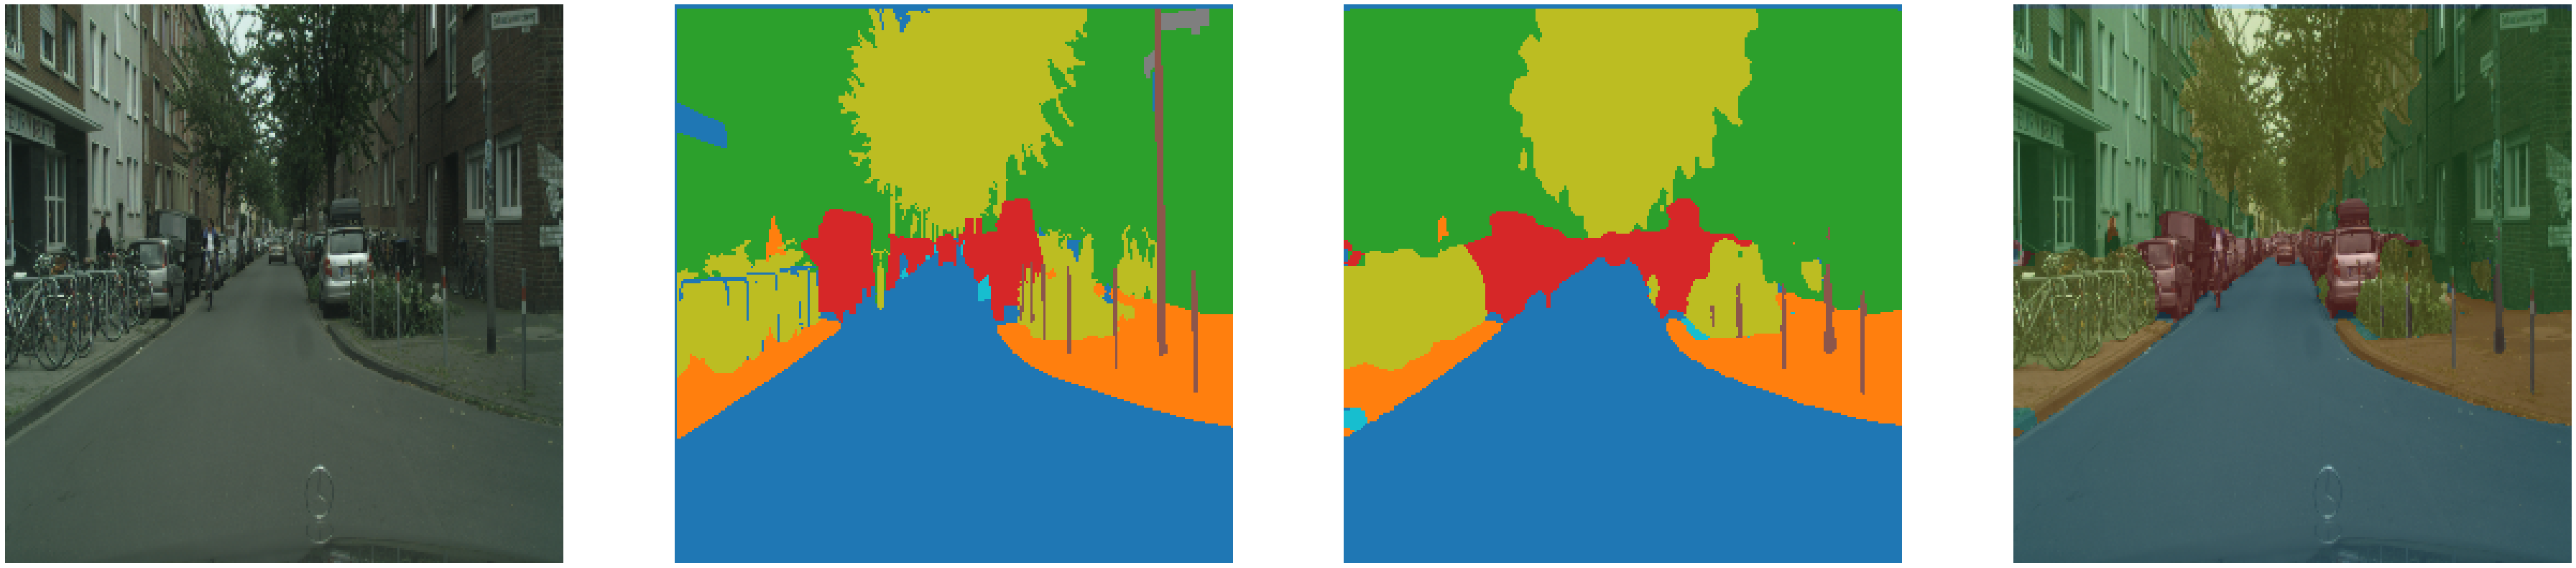

In [103]:
v = 0  # 0 to batch_size-1
img, true_mask, _ = x_val.__getitem__(19)  #  ((batch, size * size, 3), (batch, size * size, 1))
img, true_mask = img[v], true_mask[v]
true_mask[true_mask >= num_classes] = 0
true_mask = np.reshape(true_mask, (image_size,image_size)).astype(np.uint8) # (shape * shape, 1) to (shape, shape, 1)
showInference(model.model, img, deepcopy(true_mask))
print(mIoU(model.model, img, deepcopy(true_mask)))
# print(mIoU_all_images(model.model, x_val))